In [5]:
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import numpy as np

def assign_session_ids(df):
    """
    Assigns unique session IDs based on is_session_start markers.
    Messages are grouped into sessions between start markers.
    """
    df = df.sort_values(['gpt_channel_id', 'created_at'])
    
    # Generate session ID when we see a session start
    df['session_id'] = None
    current_sessions = {}  # Track active session per channel
    
    for idx, row in df.iterrows():
        channel_id = row['gpt_channel_id']
        
        # Start new session if marked or first message in channel
        if row.get('is_session_start') == 1 or channel_id not in current_sessions:
            session_id = f"{channel_id}_{row['created_at'].strftime('%Y%m%d_%H%M%S')}_{uuid.uuid4().hex[:8]}"
            current_sessions[channel_id] = session_id
        
        df.at[idx, 'session_id'] = current_sessions[channel_id]
    
    return df
def print_session_stats(df):

    # Session analysis
    session_stats = df.groupby('session_id').agg({
        'gpt_stream_id': 'count',  # message count
        'created_at': ['min', 'max'],  # session start/end
        'gpt_channel_id': 'first',  # channel id
        'user_role': lambda x: (x == 'joy').sum()  # joy message count
    }).round(2)

    session_stats.columns = ['msg_count', 'start_time', 'end_time', 'channel_id', 'joy_msgs']
    session_stats['duration_mins'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds() / 60
    session_stats['user_msgs'] = session_stats['msg_count'] - session_stats['joy_msgs']

    print("SESSION LENGTH DISTRIBUTION:")
    print(session_stats['msg_count'].describe())
    print(f"\nSessions with 1 message: {(session_stats['msg_count'] == 1).sum()}")
    print(f"Sessions with >10 messages: {(session_stats['msg_count'] >= 5).sum()}")

    print(f"\nSESSION DURATION DISTRIBUTION (minutes):")
    print(session_stats[session_stats['duration_mins'] > 0]['duration_mins'].describe())

    print(f"\nTOTAL SESSIONS: {len(session_stats)}")
    print(f"UNIQUE CHANNELS: {session_stats['channel_id'].nunique()}")
    print(f"AVG SESSIONS PER CHANNEL: {len(session_stats) / session_stats['channel_id'].nunique():.1f}")

    # number of sessions with 1 - 10+ messages
    print(f"Sessions with 1 messages: {(session_stats['msg_count'] == 1).sum()}")
    print(f"Sessions with 2 messages: {(session_stats['msg_count'] == 2).sum()}")
    print(f"Sessions with 3 messages: {(session_stats['msg_count'] == 3).sum()}")
    print(f"Sessions with 4 messages: {(session_stats['msg_count'] == 4).sum()}")
    print(f"Sessions with 5 messages: {(session_stats['msg_count'] == 5).sum()}")
    print(f"Sessions with 6 messages: {(session_stats['msg_count'] == 6).sum()}")
    print(f"Sessions with 7 messages: {(session_stats['msg_count'] == 7).sum()}")
    print(f"Sessions with 8 messages: {(session_stats['msg_count'] == 8).sum()}")
    print(f"Sessions with 9 messages: {(session_stats['msg_count'] == 9).sum()}")
    print(f"Sessions with 10 messages: {(session_stats['msg_count'] == 10).sum()}")
    print(f"Sessions with 11+ messages: {(session_stats['msg_count'] >= 11).sum()}")


    # Quick viz
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Message count distribution
    session_stats['msg_count'].hist(bins=20, ax=axes[0])
    axes[0].set_title('Messages per Session')
    axes[0].set_xlabel('Message Count')

    # Duration distribution (non-zero only)
    duration_data = session_stats[session_stats['duration_mins'] > 0]['duration_mins']
    duration_data.hist(bins=20, ax=axes[1])
    axes[1].set_title('Session Duration (mins)')
    axes[1].set_xlabel('Minutes')

    plt.tight_layout()
    plt.show()



df = pd.read_excel('../data/labelled_joy_sessions.xlsx')
df['created_at'] = pd.to_datetime(df['created_at'])

df = assign_session_ids(df)

df.head(1)

df.to_csv('../data/labelled_joy_sessions_with_sessions.csv', index=False)

In [4]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]


In [34]:

# SAVE TO EXCEL
df['created_at'] = df['created_at'].dt.tz_localize(None)
df.to_excel('../data/labelled_joy_sessions_with_sessions.xlsx', index=False)

SESSION LENGTH DISTRIBUTION:
count    635.000000
mean       4.593701
std        8.785310
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       67.000000
Name: msg_count, dtype: float64

Sessions with 1 message: 454
Sessions with >10 messages: 119

SESSION DURATION DISTRIBUTION (minutes):
count      181.000000
mean      2052.576055
std       5224.290362
min          0.038517
25%          1.684983
50%         50.989317
75%       1546.763800
max      52117.016067
Name: duration_mins, dtype: float64

TOTAL SESSIONS: 635
UNIQUE CHANNELS: 50
AVG SESSIONS PER CHANNEL: 12.7
Sessions with 1 messages: 454
Sessions with 2 messages: 32
Sessions with 3 messages: 15
Sessions with 4 messages: 15
Sessions with 5 messages: 5
Sessions with 6 messages: 5
Sessions with 7 messages: 2
Sessions with 8 messages: 10
Sessions with 9 messages: 2
Sessions with 10 messages: 8
Sessions with 11+ messages: 87


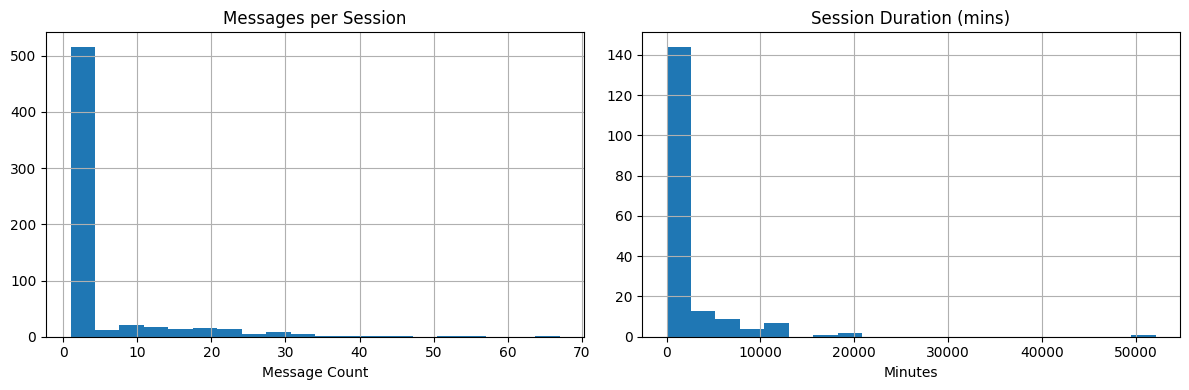

In [6]:
print_session_stats(df)

In [ ]:
# Fixed version of the evaluation code
import random
import pandas as pd
import numpy as np
from openai import OpenAI
import os
from tqdm import tqdm
import json

# Initialize OpenAI client (uncomment if you want to run the evaluation)
# client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

# Create ground truth labels (where session changes occur)
df['is_boundary'] = df.groupby('gpt_channel_id')['session_id'].transform(lambda x: x != x.shift(1))

def safe_text_slice(text, max_length=200):
    """Safely slice text, handling NaN values"""
    if pd.isna(text):
        return ""
    return str(text)[:max_length]

def create_sliding_window_examples(df, window_size=5):
    """Create examples with context window for each potential boundary"""
    examples = []
    
    for channel_id in df['gpt_channel_id'].unique():
        channel_msgs = df[df['gpt_channel_id'] == channel_id].reset_index(drop=True)
        
        # Calculate time gaps between messages
        channel_msgs['time_gap'] = channel_msgs['created_at'].diff().dt.total_seconds() / 60  # minutes
        channel_msgs['time_gap'] = channel_msgs['time_gap'].fillna(0)
        
        for i in range(1, len(channel_msgs)):  # Skip first message
            # Get context window
            start_idx = max(0, i - window_size)
            context = channel_msgs.iloc[start_idx:i]
            current = channel_msgs.iloc[i]
            
            # Format messages for prompt
            context_formatted = []
            for _, msg in context.iterrows():
                context_formatted.append({
                    'time_gap': f"+{msg['time_gap']:.0f}m" if msg['time_gap'] > 0 else "0m",
                    'role': msg['user_role'],
                    'text': safe_text_slice(msg['text'])
                })
            
            examples.append({
                'channel_id': channel_id,
                'index': i,
                'context': context_formatted,
                'current_message': {
                    'time_gap': f"+{current['time_gap']:.0f}m" if current['time_gap'] > 0 else "0m",
                    'role': current['user_role'],
                    'text': safe_text_slice(current['text'])
                },
                'is_boundary': current['is_boundary']
            })
    
    return examples

# Test the function
print("Testing the fixed function...")
examples = create_sliding_window_examples(df, window_size=3)
print(f"Created {len(examples)} evaluation examples")

# Show a sample example
if examples:
    print("\nSample example:")
    sample = examples[0]
    print(f"Channel ID: {sample['channel_id']}")
    print(f"Is boundary: {sample['is_boundary']}")
    print(f"Context messages: {len(sample['context'])}")
    print(f"Current message: {sample['current_message']['role']} - {sample['current_message']['text'][:50]}...")
    
    # Show boundary statistics
    boundary_count = sum(1 for ex in examples if ex['is_boundary'])
    print(f"\nBoundary statistics:")
    print(f"Total examples: {len(examples)}")
    print(f"Boundary examples: {boundary_count}")
    print(f"Non-boundary examples: {len(examples) - boundary_count}")
    print(f"Boundary ratio: {boundary_count / len(examples):.3f}")


In [ ]:
# Complete evaluation functions (uncomment client initialization above to use)

def create_prompt(example):
    """Create prompt with few-shot examples"""
    
    few_shot_examples = """
Example 1:
Context:
[+2m] patient: Hi, I need help with my prescription
[+30s] joy: Hello! I'd be happy to help you with your prescription. What specific assistance do you need?
[+1m] patient: I can't find where to upload my documents

Current message:
[+3d] patient: What exercises do you recommend for weight loss?

Is this a NEW SESSION? YES - Topic shifted from prescription help to exercise recommendations after 3 days.

Example 2:
Context:
[+5m] patient: I'm interested in starting the weight loss program
[+1m] joy: That's great! I can help you get started. First, I'll need some information about your health history.
[+2m] patient: Sure, what do you need to know?

Current message:
[+30s] joy: Could you tell me about any current medications you're taking?

Is this a NEW SESSION? NO - Continuation of the weight loss program enrollment discussion.

Example 3:
Context:
[+1h] joy: Your prescription has been approved! You should receive it within 2-3 business days.
[+5m] patient: Thank you so much!

Current message:
[+2h] patient: Actually, can I change the delivery address?

Is this a NEW SESSION? NO - Still related to the same prescription delivery, just a follow-up question.
"""
    
    # Format context
    context_str = "\\n".join([
        f"[{msg['time_gap']}] {msg['role']}: {msg['text']}"
        for msg in example['context']
    ])
    
    current_str = f"[{example['current_message']['time_gap']}] {example['current_message']['role']}: {example['current_message']['text']}"
    
    prompt = f"""You are analysing a customer service chat to identify session boundaries. A new session starts when there's a noticeable shift in topic or intent.

{few_shot_examples}

Now analyse this conversation:

Context:
{context_str}

Current message:
{current_str}

Is this a NEW SESSION? Answer only YES or NO, then provide a brief reason."""
    
    return prompt

def evaluate_model(examples, sample_size=100, model="gpt-4o"):
    """Run evaluation on a sample of examples"""
    
    # Sample examples
    sample_indices = np.random.choice(len(examples), min(sample_size, len(examples)), replace=False)
    sampled_examples = [examples[i] for i in sample_indices]
    
    predictions = []
    true_labels = []
    
    print(f"Evaluating {len(sampled_examples)} examples...")
    
    for example in tqdm(sampled_examples):
        prompt = create_prompt(example)
        
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are an expert at identifying conversation session boundaries."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0,
                max_tokens=100
            )
            
            response_text = response.choices[0].message.content.strip()
            prediction = 1 if response_text.upper().startswith("YES") else 0
            
            predictions.append(prediction)
            true_labels.append(1 if example['is_boundary'] else 0)
            
        except Exception as e:
            print(f"Error: {e}")
            predictions.append(0)  # Default to not boundary
            true_labels.append(1 if example['is_boundary'] else 0)
    
    # Calculate metrics
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    accuracy = (predictions == true_labels).mean()
    precision = (predictions[predictions == 1] == true_labels[predictions == 1]).mean() if (predictions == 1).any() else 0
    recall = (predictions[true_labels == 1] == true_labels[true_labels == 1]).mean() if (true_labels == 1).any() else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Confusion matrix
    tp = ((predictions == 1) & (true_labels == 1)).sum()
    fp = ((predictions == 1) & (true_labels == 0)).sum()
    tn = ((predictions == 0) & (true_labels == 0)).sum()
    fn = ((predictions == 0) & (true_labels == 1)).sum()
    
    print("\\n=== Evaluation Results ===")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"\\nConfusion Matrix:")
    print(f"TP: {tp}, FP: {fp}")
    print(f"FN: {fn}, TN: {tn}")
    print(f"\\nClass balance: {true_labels.mean():.3f} positive examples")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Uncomment below to run the evaluation (requires OpenAI API key)
"""
# Run the evaluation
results = evaluate_model(examples, sample_size=50, model="gpt-4o")

# Save results for analysis
with open('../data/evaluation_results.json', 'w') as f:
    json.dump({
        'metrics': {k: float(v) for k, v in results.items() if k not in ['predictions', 'true_labels']},
        'predictions': results['predictions'].tolist(),
        'true_labels': results['true_labels'].tolist()
    }, f, indent=2)
"""

print("Evaluation functions defined. Uncomment the code above and ensure you have an OpenAI API key to run the evaluation.")
